In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import torch
import torchvision
from torchvision import models
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm_notebook
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
import time



---



In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
def train_valid_split(dataset):
    X_train, X_test = train_test_split(
        dataset, test_size=0.05, random_state=13)
    return X_train, X_test

In [5]:
policy = T.AutoAugmentPolicy.IMAGENET
applier = T.RandomApply(transforms=[T.AutoAugment(policy)], p=0.2)
augm = T.Compose([applier, T.ToTensor()])

In [6]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [7]:
train_dataset = torchvision.datasets.CIFAR100(root='./data',
                                              train=True,
                                              transform=T.ToTensor(),
                                              download=True)

train_dataset_aug = torchvision.datasets.CIFAR100(root='./data',
                                                  train=True,
                                                  transform=augm,
                                                  download=True)

dataset = torchvision.datasets.CIFAR100(root='./data',
                                        train=False,
                                        download=True,
                                        transform=T.ToTensor())

test_dataset, valid_dataset = train_valid_split(dataset)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
labels_name = train_dataset.classes

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           drop_last=True,
                                           num_workers=3)

train_loader_aug = torch.utils.data.DataLoader(dataset=train_dataset_aug,
                                               batch_size=128,
                                               shuffle=True,
                                               drop_last=True,
                                               num_workers=3)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           drop_last=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          drop_last=True,
                                          num_workers=3)

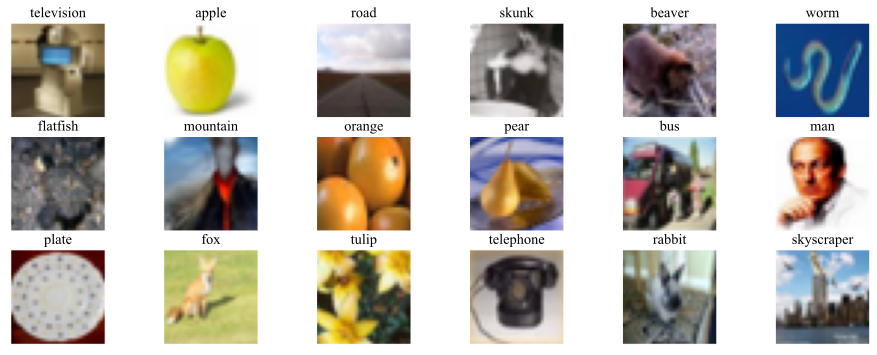

In [10]:
N = 18
sample_idx = np.random.randint(0, 5000, N)

fig = plt.figure(figsize=(16, 8))
for j, idx in enumerate(sample_idx):
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(train_dataset[idx][0].permute(1, 2, 0).numpy())
    plt.xticks([])
    plt.yticks([])
    plt.title(labels_name[train_dataset[idx][1]])
    plt.grid(False)
plt.show()



---



# Обучить классификатора картинок на примере CIFAR-100 сверточной сетью (самописной)

In [11]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dp_1 = nn.Dropout(0.5)
        self.dp_2 = nn.Dropout(0.25)
        self.dp_3 = nn.Dropout(0.1)

        self.bn_1 = torch.nn.BatchNorm2d(3)
        self.conv_1 = torch.nn.Conv2d(3, 64, 3, padding='same')
        self.bn_2 = torch.nn.BatchNorm2d(64)
        self.conv_2 = torch.nn.Conv2d(64, 64, 2, padding='same')
        self.bn_3 = torch.nn.BatchNorm2d(64)
        self.conv_3 = torch.nn.Conv2d(64, 128, 3, padding='same')
        self.bn_4 = torch.nn.BatchNorm2d(128)
        self.conv_4 = torch.nn.Conv2d(128, 128, 2, padding='same')
        self.bn_5 = torch.nn.BatchNorm2d(128)
        self.conv_5 = torch.nn.Conv2d(128, 256, 2, padding='same')
        self.bn_6 = torch.nn.BatchNorm2d(256)
        self.fc1 = torch.nn.Linear(256, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.out = torch.nn.Linear(256, 100)

    def forward(self, x):
        x = self.bn_1(x)
        x = self.conv_1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_2(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_3(x)
        x = self.conv_3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_4(x)
        x = self.conv_4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_5(x)
        x = self.conv_5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_6(x)
        x = x.view(x.size(0), -1)
        x = self.dp_2(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_3(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.out(x)
        return x


net = MyNet()
net.to(device)

MyNet(
  (dp_1): Dropout(p=0.5, inplace=False)
  (dp_2): Dropout(p=0.25, inplace=False)
  (dp_3): Dropout(p=0.1, inplace=False)
  (bn_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (bn_5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (bn_6): BatchNorm2d(256, eps=1e-05,

In [12]:
def model_eval(model, opt, loss_func, dataset_loader):

    num_batches = len(dataset_loader)
    test_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataset_loader:
            pred = model(X.to(device))
            test_loss += loss_func(pred, y.to(device)).item()
            _, predicted = torch.max(pred, 1)
            total += y.size(0)
            correct += (predicted.to(device) == y.to(device)).sum().item()

        test_loss = round(test_loss / num_batches, 4)
        accuracy = round(100 * correct / total, 2)

    return test_loss, accuracy

In [13]:
def train_step(epoch, train_start_time, model, opt, loss_func, train_loader):

    time_start = time.time()
    running_loss = 0
    num_batches_train = len(train_loader)

    for num, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)

        opt.zero_grad()  # обнуляем градиент
        outputs = model(images)  # получаем предсказания
        loss = loss_func(outputs, labels)  # считаем потери
        loss.backward()  # ОРО
        opt.step()  # обновление весов

        running_loss += loss.item()

    test_loss, accuracy = model_eval(model, opt, loss_func, valid_loader)
    train_loss = round(running_loss / num_batches_train, 4)

    if (epoch+1) % 5 == 0:
        time_taken = round(time.time() - time_start, 1)
        from_start = round(time.time() - train_start_time, 1)
        print(
            f'Epoch № {epoch+1}, tr_loss= {train_loss}, eval_loss= {test_loss},',
            f'accuracy = {accuracy}',
            f'\ntime_per_epoch = {time_taken} sec, total ---> {from_start} sec'
        )
    return accuracy

In [14]:
EPOCHES = 70
LR = 0.00001

In [15]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=LR)

In [16]:
train_start = time.time()
acc_history = []
for epoch in tqdm_notebook(range(EPOCHES)):
    accuracy = train_step(epoch, train_start, net,
                          opt, loss_func, train_loader)
    acc_history.append(accuracy)
print('*'*100)
print(f'Training is finished! Best score: {max(acc_history)} Time taken, sec:',
      time.time()-train_start)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch № 5, tr_loss= 4.072, eval_loss= 3.9492, accuracy = 9.64 
time_per_epoch = 19.3 sec, total ---> 98.1 sec
Epoch № 10, tr_loss= 3.5647, eval_loss= 3.5082, accuracy = 17.19 
time_per_epoch = 19.9 sec, total ---> 197.2 sec
Epoch № 15, tr_loss= 3.2645, eval_loss= 3.2719, accuracy = 21.61 
time_per_epoch = 19.5 sec, total ---> 294.7 sec
Epoch № 20, tr_loss= 3.0503, eval_loss= 3.1138, accuracy = 22.14 
time_per_epoch = 19.5 sec, total ---> 391.9 sec
Epoch № 25, tr_loss= 2.8762, eval_loss= 2.9991, accuracy = 25.0 
time_per_epoch = 19.6 sec, total ---> 489.4 sec
Epoch № 30, tr_loss= 2.7395, eval_loss= 2.8975, accuracy = 28.65 
time_per_epoch = 19.7 sec, total ---> 587.0 sec
Epoch № 35, tr_loss= 2.6126, eval_loss= 2.8045, accuracy = 30.73 
time_per_epoch = 20.9 sec, total ---> 686.3 sec
Epoch № 40, tr_loss= 2.5059, eval_loss= 2.7874, accuracy = 30.99 
time_per_epoch = 19.2 sec, total ---> 783.9 sec
Epoch № 45, tr_loss= 2.4085, eval_loss= 2.7091, accuracy = 30.21 
time_per_epoch = 18.9 sec, 



---



# Обучить классификатора картинок на примере CIFAR-100 через дообучение ImageNet Resnet-50


In [17]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = True
resnet.fc = nn.Linear(2048, 512)
_resnet = nn.Sequential(
    resnet,
    nn.Dropout2d(0.6),
    nn.Linear(512, 100))

_resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\BATMAN/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [18]:
EPOCHES = 30
LR = 0.00001

In [19]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(_resnet.parameters(), lr=LR)

In [ ]:
train_start = time.time()
acc_history = []
for epoch in tqdm_notebook(range(EPOCHES)):
    accuracy = train_step(epoch, train_start, _resnet,
                          opt, loss_func, train_loader)
    acc_history.append(accuracy)
print('*'*100)
print(f'Training is finished! Best score: {max(acc_history)} Time taken, sec:',
      time.time()-train_start)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch № 5, tr_loss= 2.5301, eval_loss= 2.5092, accuracy = 36.98 
time_per_epoch = 57.4 sec, total ---> 287.3 sec




---



# Обучить классификатора картинок на примере CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией (самописной, с использованием Pytorch встроенных методов)



In [ ]:
resnet_aug = models.resnet50(pretrained=True)
for param in resnet_aug.parameters():
    param.requires_grad = True
resnet_aug.fc = nn.Linear(2048, 512)
_resnet_aug = nn.Sequential(
    resnet_aug,
    nn.Dropout2d(0.6),
    nn.Linear(512, 100))

_resnet_aug.to(device)

In [ ]:
EPOCHES = 30
LR = 0.00001

In [ ]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(_resnet_aug.parameters(), lr=LR)

In [ ]:
train_start = time.time()
acc_history = []
for epoch in tqdm_notebook(range(EPOCHES)):
    accuracy = train_step(epoch, train_start, _resnet_aug,
                          opt, loss_func, train_loader_aug)
    acc_history.append(accuracy)
print('*'*100)
print(f'Training is finished! Best score: {max(acc_history)} Time taken, sec:',
      time.time()-train_start)

# Сравнить качество на валидации(фиксированный сет), прокомментировать различия в качестве и в скорости работы